<a href="https://colab.research.google.com/github/MurtazAlek/MLDM-2021/blob/main/Murtazina%22MLDM_2021_seminar05_homework%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please, fill in before you start:
First Name: **Aleksandra**

Last Name: **Murtazina**

Group:

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [ ]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [ ]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [ ]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9200000000000002


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

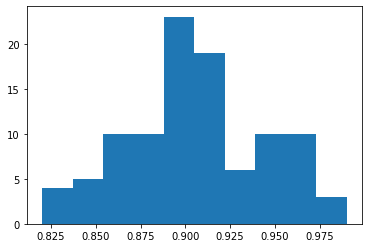

In [ ]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (6 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem.

*Hint: the problem is in the overall logic, and not a bug in the code.*

Не будет работать корректно, так как мы производим манипуляции с данными и "вмешиваем" в это у - отклик. Такие манипуляции с дпнными производить нельзя. Однако это не значит что вообще никакие манипуляции производить нельзя. Например можно исключить признаки с максимальной дисперсией, так как это не затрагивает отклик y. Если в задаче рассчитать accuracy на исходных данных, то все сойдется ожидаемая ошибка будет около 0.5 

In [ ]:
from sklearn.model_selection import train_test_split
model=LinearSVC()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=16)
model.fit(X_train, y_train)
test_predictions=model.predict(X_test)
accuracy=accuracy_score(y_test,test_predictions)
print(accuracy)

0.52


рассчиаем среднюю корреляцию с откликом ...должна быть около нуля так как изначально данные гененировались независимо от отклика

In [ ]:
import random
random_set=random.sample(list(range(0,N)),30)

covariance_X_10 = ( (np.take(X,random_set,axis=0) - np.take(X,random_set,axis=0).mean(axis=0))
                 * (np.take(y[:,np.newaxis],random_set,axis=0) - np.take(y,random_set,axis=0).mean()) ).mean(axis=0)

covariance_X = ((X - X.mean(axis=0))* (y[:,np.newaxis] - y.mean())).mean(axis=0)


covariance_X_best = ((X_best - X_best.mean(axis=0))*(y[:,np.newaxis] - y.mean())).mean(axis=0)


covariance_X_best_10 = ( (np.take(X_best,random_set,axis=0) - np.take(X_best,random_set,axis=0).mean(axis=0))
                      * (np.take(y[:,np.newaxis],random_set,axis=0) - np.take(y,random_set,axis=0).mean()) ).mean(axis=0)


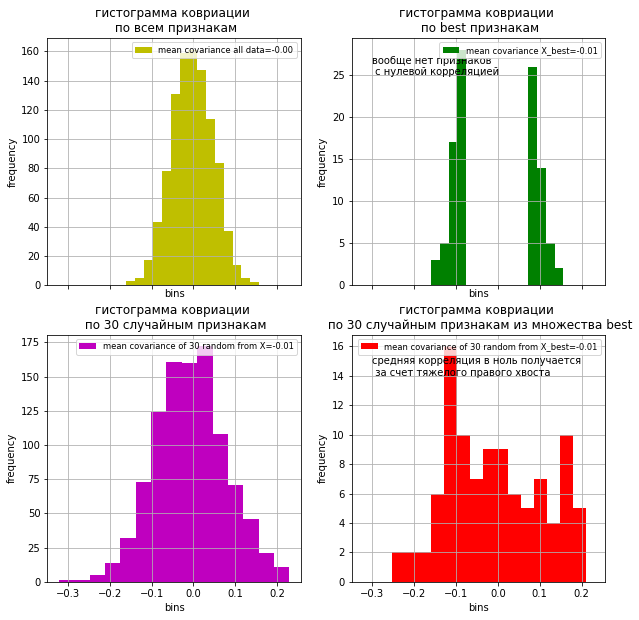

In [ ]:
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), squeeze=False, sharex=True)
ax_1=axes[0][0]
ax_1.hist(covariance_X,bins=15, color='y',label='mean covariance all data=%0.2f'% covariance_X.mean())
ax_1.set_xlabel('bins', fontsize=10)
ax_1.set_ylabel('frequency', fontsize=10)
ax_1.grid()
ax_1.set_title('гистограмма ковриации \n по всем признакам')
legend_1 = ax_1.legend(loc=0, shadow=False, fontsize='small')


ax_2=axes[0][1]
ax_2.hist(covariance_X_best,bins=15, color='g',label='mean covariance X_best=%0.2f'% covariance_X_best.mean())
ax_2.set_xlabel('bins', fontsize=10)
ax_2.set_ylabel('frequency', fontsize=10)
ax_2.grid()
ax_2.set_title('гистограмма ковриации \n по ''best'' признакам')
ax_2.text(-0.3,25, 'вообще нет признаков \n с нулевой корреляцией')
legend_2 = ax_2.legend(loc=0, shadow=False, fontsize='small')


ax_11=axes[1][0]
ax_11.hist(covariance_X_10,bins=15, color='m',label='mean covariance of 30 random from X=%0.2f'% covariance_X_10.mean())
ax_11.set_xlabel('bins', fontsize=10)
ax_11.set_ylabel('frequency', fontsize=10)
ax_11.grid()
ax_11.set_title('гистограмма ковриации \n по 30 случайным признакам')
legend_11 = ax_11.legend(loc=0, shadow=False, fontsize='small')

ax_3=axes[1][1]
ax_3.hist(covariance_X_best_10,bins=15, color='r',label='mean covariance of 30 random from X_best=%0.2f'% covariance_X_best_10.mean())
ax_3.set_xlabel('bins', fontsize=10)
ax_3.set_ylabel('frequency', fontsize=10)
ax_3.grid()
ax_3.text(-0.3, 14, 'средняя корреляция в ноль получается \n за счет тяжелого правого хвоста')
ax_3.set_title('гистограмма ковриации \n по 30 случайным признакам из множества best')
legend_3 = ax_3.legend(loc=0, shadow=False, fontsize='small')
plt.show()

In [ ]:
training_error=[]
for i in range(X.shape[1]):
    model.fit(X[:,i].reshape(-1,1),y)
    train_prediction=model.predict(X[:,i].reshape(-1,1))
    training_error.append(np.sum(np.abs(train_prediction-y)))
training_error=np.array(training_error)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=16)

training_error_split=[]
test_error_split=[]
train_prediction=[]
test_prediction=[]
for i in range(X.shape[1]):
    model.fit(X_train[:,i].reshape(-1,1),y_train)

    train_prediction1=model.predict(X_train[:,i].reshape(-1,1))
    train_prediction.append(train_prediction1)
    training_error_split.append(np.sum(np.abs(train_prediction1-y_train)))

    test_prediction1 = model.predict(X_test[:, i].reshape(-1, 1))
    test_prediction.append(test_prediction1)
    test_error_split.append(np.sum(np.abs(test_prediction1 - y_test)))

training_error_split=np.array(training_error_split)
test_error_split=np.array(test_error_split)
test_prediction=np.array(test_prediction)
train_prediction=np.array(train_prediction)

scores=[]
for d in range(50):
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)
    model_cv=LinearSVC()
    cv = KFold(n_splits=5,shuffle=True)
    scores.append(cross_val_score(model_cv, X, y, scoring='accuracy', cv=cv).mean())
scores=np.array(scores)


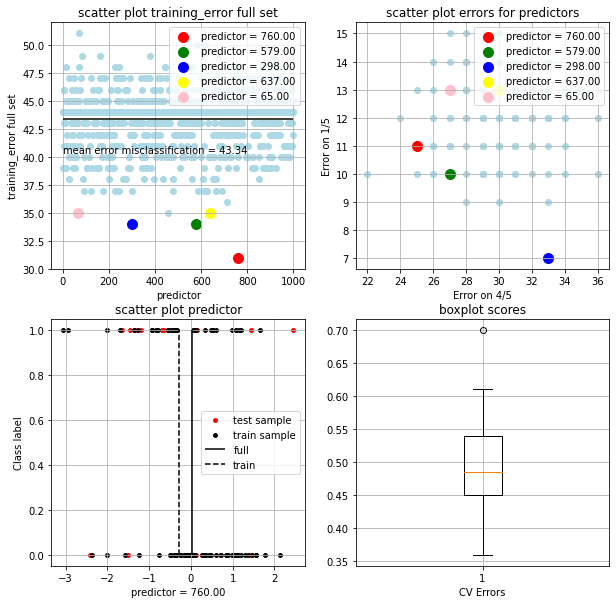

In [ ]:
fig_1, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10),squeeze=False)

n=5
model_full=LinearSVC()
model_full.fit(X[:,np.argsort(training_error)[:n][0]].reshape(-1,1),y)

model_train=LinearSVC()
model_train.fit(X_train[:,np.argsort(training_error)[:n][0]].reshape(-1,1),y_train)

col = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"])

ax_1=axes[0][0]
ax_1.scatter(range(X.shape[1]),training_error, color='lightblue')
for counter, value in enumerate( np.argsort(training_error)[:n]):
    ax_1.scatter(value,training_error[value], color=col[counter],s=100,label='predictor = %0.2f'% value)
ax_1.hlines(np.mean(training_error),xmin=0,xmax=1000,color='black')
ax_1.text(0, np.mean(training_error)-3, 'mean error misclassification = %0.2f'% np.mean(training_error))
ax_1.set_xlabel('predictor', fontsize=10)
ax_1.set_ylabel('training_error full set', fontsize=10)
ax_1.grid()
ax_1.set_title('scatter plot training_error full set')
ax_1.legend(loc =1)


ax_2=axes[0][1]
ax_2.scatter(training_error_split,test_error_split, color='lightblue')
for counter, value in enumerate( np.argsort(training_error)[:n]):
    ax_2.scatter(training_error_split[value],test_error_split[value], color=col[counter],s=100, label='predictor = %0.2f'% value)
ax_2.set_xlabel('Error on 4/5', fontsize=10)
ax_2.set_ylabel('Error on 1/5', fontsize=10)
ax_2.grid()
ax_2.set_title('scatter plot errors for predictors')
ax_2.legend(loc =1)

ax_3=axes[1][0]
ax_3.scatter(X_test[:,np.argsort(training_error)[:n][0]],y_test,color='red', s=15,label='test sample')
ax_3.scatter(X_train[:,np.argsort(training_error)[:n][0]],y_train,marker='o',color='black',edgecolors='face',s=15,label='train sample')
ax_3.vlines(model_full.coef_,ymin=0, ymax=1, colors='black', linestyles='solid', label='full')
ax_3.vlines(model_train.coef_,ymin=0, ymax=1, colors='black', linestyles='dashed', label='train')
ax_3.set_xlabel('predictor = %0.2f'% np.argsort(training_error)[:n][0], fontsize=10)
ax_3.set_ylabel('Class label', fontsize=10)
ax_3.grid()
ax_3.set_title('scatter plot predictor')
ax_3.legend(loc =0)

ax_4=axes[1][1]
ax_4.boxplot(scores)
ax_4.set_xlabel('CV Errors', fontsize=10)
ax_4.grid()
ax_4.set_title('boxplot scores')
plt.show()

На первом графике расссеяния показано колличество ошибок каждого предиката на полном датасете. Цветами обозначены 6 предикатов с минимальной ошибкой. Красный обозначен предикат с минимальной ошибкой.

На втором графике те же самые предикаты, но датасет разбили на тестовую и тренировочную выборки (1/5 и 4/5 соответственно).

На третьем графике выбран "лучший" предикат. для него рассчитан split point на основе всей выборки и тренировочной.

На четвертом графике показан boxplot 5-cv примененных к 50 сгенерированным датасетам. Очевидно что средняя ошибка около 0.5 как и должно быть.